<a href="https://colab.research.google.com/github/danielzt12/AD_LTEM/blob/ALCF/AD_LTEM_PyTorch_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
from skimage.restoration import unwrap_phase, denoise_tv_chambolle
import numpy as np
import tifffile as tif
from matplotlib import pyplot, colors
import sys, time
from scipy import ndimage
from scipy.fftpack import *
import gdown
from scipy.signal import fftconvolve

# will be available once we get the approval
# sys.path.append("AD_LTEM")

from torch.cuda import get_device_name
print("GPU:", get_device_name(0))

GPU: Tesla K80


In [8]:
!pip install fabio
import fabio

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
!gdown "http://drive.google.com/uc?id=1S6RFU3eTiHVM6wN5YfS7VBk6NzmATi54"
expdata = fabio.open("FS4_restest_q_10mu_1s_alimj_crp.tif")

Downloading...
From: http://drive.google.com/uc?id=1S6RFU3eTiHVM6wN5YfS7VBk6NzmATi54
To: /content/FS4_restest_q_10mu_1s_alimj_crp.tif
105MB [00:00, 170MB/s] 


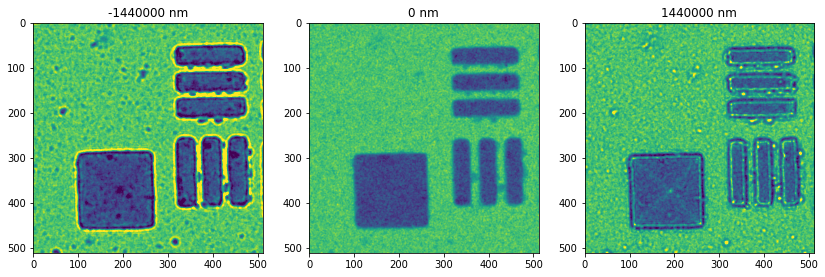

In [11]:
A_samples = np.zeros((25,512,512))

for i in range(25):
  A_samples[i] =  expdata.getframe(i).data[185-13:697-13,:512]

A_samples = np.sqrt(A_samples)
A_samples/=A_samples.mean(1).mean(1)[:,np.newaxis,np.newaxis]

defocus = np.array([-1440000,-1210000,-1000000,-810000,-640000,-490000,-360000,-250000,-160000,-90000,-40000,-10000,0,\
                      10000,40000,90000,160000,250000,360000,490000,640000,810000,1000000,1210000,1440000])

f, ax = pyplot.subplots(ncols=3, figsize = (14,8))
ax[0].imshow(A_samples[0], cmap='viridis', norm=colors.Normalize(A_samples[12].min(), A_samples[12].max()))
ax[0].set_title("{0} nm".format(defocus[0]))
ax[1].imshow(A_samples[12], cmap='viridis', norm=colors.Normalize(A_samples[12].min(), A_samples[12].max()))
ax[1].set_title("{0} nm".format(defocus[12]))
ax[2].imshow(A_samples[24], cmap='viridis', norm=colors.Normalize(A_samples[12].min(), A_samples[12].max()))
ax[2].set_title("{0} nm".format(defocus[24]));

In [61]:
# rewriting the microscope transfer function with tensorflow

import scipy.constants as physcon

[dim,dim] = A_samples[12].shape
d2=dim/2
line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = torch.tensor(np.sqrt(X**2 + Y**2) / float(dim), dtype=torch.float32, requires_grad=True, device=device)

del_px = 6.9 #nm/px

E = 200.0e3
Cs=1.0e6
Cc=5.0e6
Ca=0.0e6
phi_a=0
def_spr = 500

epsilon = 0.5 * physcon.e / physcon.m_e / physcon.c**2
lam = physcon.h * 1.0e9 / np.sqrt(2.0 * physcon.m_e * physcon.e) / np.sqrt(E + epsilon * E**2)
gamma = 1.0 + physcon.e * E / physcon.m_e / physcon.c**2
sigma = 2.0 * np.pi * physcon.m_e * gamma * physcon.e * lam * 1.0e-18 / physcon.h**2

lam = lam / del_px
cs = Cs / del_px
ca = Ca / del_px
phi = 0
spread = def_spr / del_px

scale1 = 1
scale2 = 100

def getTF(defoc, theta_c):

  def_val = defoc * scale1 / del_px

  theta_c = torch.pow(10, theta_c/scale2)

  p1 = np.pi * lam * (def_val + ca * np.cos(2.0 * (phi - phi_a))) # tensor
  p2 = np.pi * cs * lam**3 * 0.5 
  p3 = 2.0 * (np.pi * theta_c * spread)**2  # a tensor
  p4 = (np.pi * lam * spread)**2
  p5 = np.pi**2 * theta_c**2 / lam**2  # a tensor
  p6 = cs * lam**3   
  p7 = def_val * lam  # a tensor
 
  u = 1.0 + p3 * qq**2 
  chiq = -p1 * qq**2 + p2 * qq**4  
  es_arg = 1.0/(2.0*u) * p4 * qq**4   
  et_arg = torch.multiply(1.0/u, torch.multiply(p5, (p6 * qq**3 - torch.multiply(p7,qq) )**2 ) )  # a tensor

  dampenv = torch.exp(es_arg-et_arg)   # a tensor
  transfer_function = torch.fft.fftshift(torch.multiply(torch.complex(torch.cos(chiq),-torch.sin(chiq)), dampenv), dim=(1,2))
  
  return transfer_function

In [76]:
def compute_loss():
  tf_obj = guess_amplitude * torch.exp(1j*guess_phase)
  cal_data = torch.fft.ifft2(torch.fft.fft2(tf_obj)*getTF(defoc, theta_c))
  cal_data = torch.abs(cal_data)
  cal_data /= torch.mean(cal_data, dim=(1,2), keepdims=True)

  return torch.mean((cal_data - exp_data)**2)

In [77]:
def training_loop(optimizer, n=1000):
    "Training loop for torch model."
    losses = []
    for i in range(n):
        loss = compute_loss()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss)  
        if i>0 and not i%500:
          print(loss, theta_c)
    return losses

In [1]:
selection = [2,5,19,22]
print("chosen defocus (mm): ", defocus[selection]/1e6)

exp_data = torch.from_numpy(A_samples[selection].astype(np.float32)).to(device)

# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = torch.tensor(denoise_tv_chambolle(A_samples[12], weight=0.025, multichannel=False), dtype=torch.float32, requires_grad=False, device=device)
# initialize the phase as 0.5 everywhere
guess_phase = torch.tensor(np.zeros(A_samples[12].shape)+0.5, dtype=torch.float32, requires_grad=True, device=device) 
print(guess_phase.type(), guess_phase.dtype)

defoc = torch.tensor(defocus[selection][:, np.newaxis, np.newaxis]/scale1, dtype=torch.float32, requires_grad=False, device=device)
theta_c = torch.tensor(-400, dtype=torch.float32, requires_grad=False, device=device) 

opt = torch.optim.Adam([guess_phase], lr=.025)

NameError: ignored

In [79]:
losses = training_loop(opt, n=1000)

tensor(0.0021, device='cuda:0', grad_fn=<MeanBackward0>) tensor(-411.2845, device='cuda:0', requires_grad=True)


# AD Phase Retrieval

In [ ]:
defocus = np.linspace(-1.6e6,1.6e6,65)

#inititiate microscope class
TEM = Microscope(Cs = 1.0e6, theta_c = 0.01e-3, def_spr = 500)

#reciprocal space vectors
[dim,dim] = true_amplitude.shape
d2=dim/2
line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = np.sqrt(X**2 + Y**2) / float(dim)

# define pixel resolution in nm.
del_px = 5 #nm/px

tf_microscope = np.zeros(A_samples.shape, dtype=np.complex64)

for i in range(defocus.shape[0]):
  TEM.defocus = defocus[i]
  tf_microscope[i] = TEM.getTransferFunction(qq, del_px)


In [ ]:
selection = [0,29,35,64]
print("chosen defocus (mm): ", defocus[selection]/1e6)

TF = torch.from_numpy(fftshift(tf_microscope[selection], axes=(1,2))).to(device)
exp_data = torch.from_numpy(A_samples[selection].astype(np.float32)).to(device)

chosen defocus (mm):  [-1.6  -0.15  0.15  1.6 ]


In [ ]:
def compute_loss():
  tf_obj = guess_amplitude * torch.exp(1j*guess_phase)
  cal_data = torch.fft.ifft2(torch.fft.fft2(tf_obj)*TF)
  cal_data = torch.abs(cal_data)
  cal_data /= torch.mean(cal_data, dim=(1,2), keepdims=True)
  return torch.mean((cal_data - exp_data)**2)

In [ ]:
#guess_amplitude = torch.tensor(denoise_tv_chambolle(A_samples[32], weight=noise/100./2, multichannel=False), dtype=torch.float32, requires_grad=False)
guess_amplitude = torch.tensor(A_samples[32], dtype=torch.float32, requires_grad=False, device=device)
guess_phase = torch.tensor(np.zeros(A_samples[32].shape)+0.5, dtype=torch.float32, requires_grad=True, device=device) 
print(guess_phase.type())
opt = torch.optim.Adam([guess_phase], lr=.025)

In [ ]:
def training_loop(optimizer, n=1000):
    "Training loop for torch model."
    losses = []
    for i in range(n):
        loss = compute_loss()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss)  
    return losses

In [ ]:
losses = training_loop(opt, n=1000)

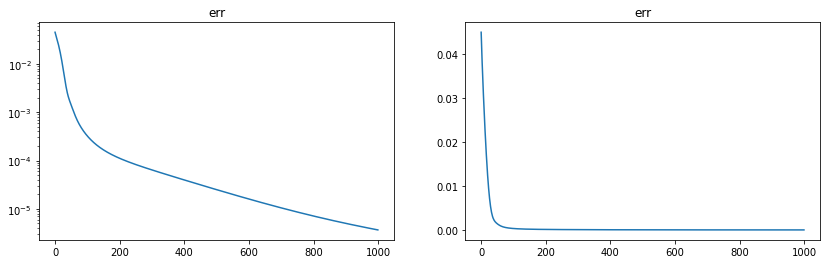

In [ ]:
f, ax = pyplot.subplots(ncols=2, figsize = (14,4))
ax[0].semilogy(losses)
ax[0].set_title("err")
ax[1].plot(losses)
ax[1].set_title("err");

In [ ]:
result_phase = guess_phase.detach().numpy()
result_phase -= result_phase.mean()

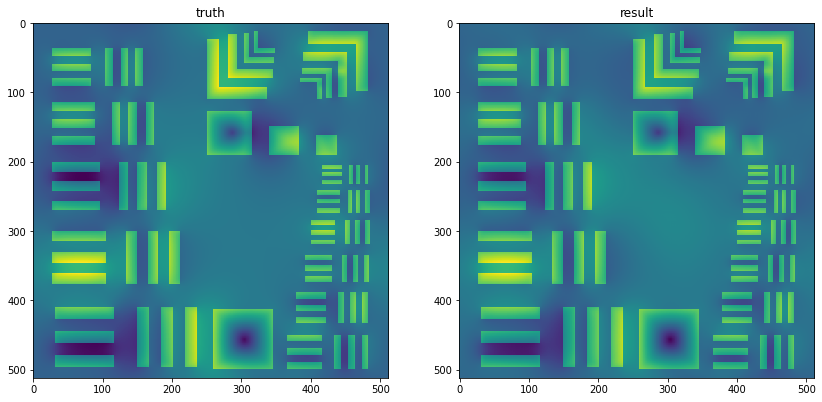

In [ ]:
# show phase
f, ax = pyplot.subplots(ncols=2, figsize = (14,8))
ax[0].imshow(true_phase, interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[0].set_title("truth")
ax[1].imshow(result_phase, interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[1].set_title("result");

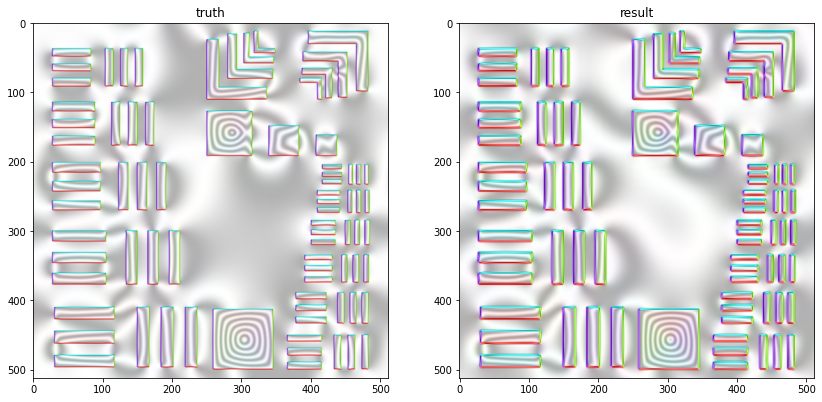

In [ ]:
from microscopes_fwd import Plot_ColorMap

# show phase gradient
f, ax = pyplot.subplots(ncols=2, figsize = (14,8))

t1 = np.copy(true_phase)
t1=ndimage.gaussian_filter(t1-np.mean(t1),0,order=0)
gx=np.gradient(t1,axis=0)
gy=np.gradient(t1,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[0].imshow(rgb_map)
ax[0].set_title("truth")
ax[0].imshow(np.cos(t1*10), cmap="gray", alpha=.3, vmin=-1, vmax=1)

t2 = np.copy(result_phase)
t2=ndimage.gaussian_filter(t2-np.mean(t2),1,order=0)
gx=np.gradient(t2,axis=0)
gy=np.gradient(t2,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[1].imshow(rgb_map)
ax[1].imshow(np.cos(t2*10), cmap="gray", alpha=.3, vmin=-1, vmax=1)
ax[1].set_title("result");

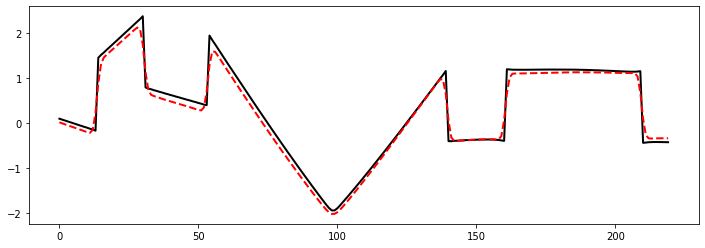

In [ ]:
fig, ax = pyplot.subplots(figsize=(12,4))
ax.plot((true_phase-true_phase.mean())[457,205:425], 'k-', linewidth=2)
ax.plot(t2[457,205:425], 'r--', linewidth=2)